In [1]:
import utils
import r_pca
import numpy as np
from pylab import plt

%load_ext autoreload
%autoreload 2

In [2]:
d = 10
n = 2 ** d
left = 0
right = 1
signal = utils.values(np.sqrt, left, right, n)
modes = [2] * d

In [3]:
filters, sparse_parts, ranks = utils.wtt_rpca_v3(
    signal,
    d,
    modes,
    ranks=None,
    eps=1e-6,
    lambda_scale=2.5,
    verbose=False
)

In [4]:
[u.shape for u in filters]

[(2, 2),
 (4, 4),
 (8, 8),
 (14, 14),
 (14, 14),
 (14, 14),
 (12, 12),
 (10, 10),
 (8, 8),
 (4, 4)]

In [5]:
[u.shape for u in sparse_parts]

[(2, 512),
 (4, 256),
 (8, 128),
 (16, 64),
 (32, 32),
 (64, 16),
 (128, 8),
 (256, 4),
 (512, 2),
 (1024, 1)]

In [6]:
[u.data.size for u in sparse_parts]

[22, 43, 42, 17, 1, 8, 12, 21, 0, 0]

In [7]:
wtt_result = utils.wtt_apply_rpca_v3(
    signal,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)

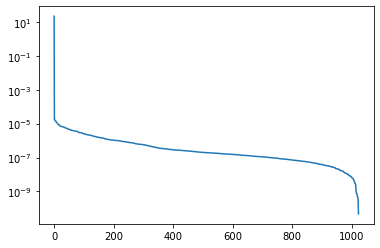

In [8]:
plt.plot(np.arange(wtt_result.size), np.flip(np.sort(np.abs(wtt_result))))
plt.yscale('log')
plt.show()

In [9]:
iwtt_result = utils.iwtt_apply_rpca_v3(
    wtt_result,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)

In [10]:
np.linalg.norm(signal - iwtt_result)

1.754480842543126e-14

Восстановим:

In [11]:
(np.abs(wtt_result) <= 1e-6).sum()

809

In [12]:
wtt_result[np.abs(wtt_result) <= 1e-6] = 0
iwtt_result = utils.iwtt_apply_rpca_v3(
    wtt_result,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)
print(np.linalg.norm(signal - iwtt_result))

8.890309034564021e-06


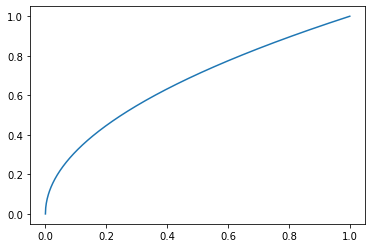

In [13]:
#plt.plot(np.linspace(left, right, n), signal)
plt.plot(np.linspace(left, right, n), iwtt_result)

Тестируем тензоризованный препроцессинг.

In [34]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    signal,
    d,
    modes,
    lambda_scale=1.25
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4
Current step 5
Current step 6
Current step 7
Current step 8
Current step 9


In [37]:
low_rank_part

array([0.2186115 , 0.21891975, 0.22316386, ..., 0.8872652 , 0.87098545,
       0.87184591])

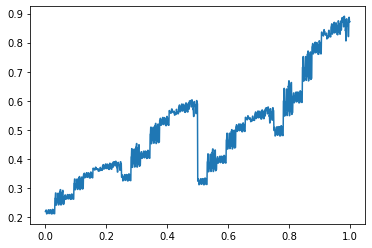

In [38]:
plt.plot(np.linspace(left, right, n), low_rank_part)

In [39]:
[s.data.size for s in sparse_parts]

[233, 360, 346, 116, 72, 158, 652, 132, 736, 922]

In [40]:
ranks

[2, 3, 4, 3, 2, 2, 2, 1, 1, 1]

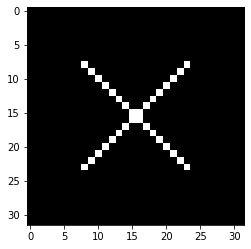

In [58]:
cross = np.zeros((32, 32))
for i in range(8, 24):
    cross[i, i] = 1.
    cross[i, 31 - i] = 1.
plt.imshow(cross, cmap='gray')

In [59]:
d = 5
modes = [2] * d

vector, vector_modes = utils.matrix_to_vector(cross, d, modes)

In [60]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    vector,
    d,
    vector_modes,
    lambda_scale=1
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4


In [61]:
matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

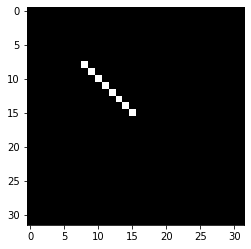

In [62]:
plt.imshow(matrix, cmap='gray')

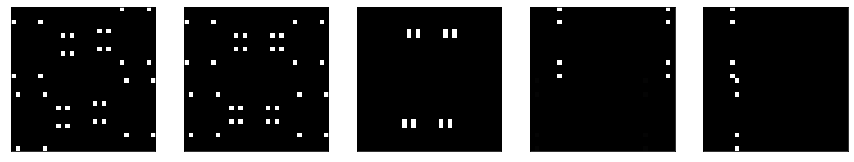

In [66]:
fig = plt.figure(figsize=(15, 3))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        sparse_parts[i].toarray().reshape((32, 32), order='F'),
        #sparse_parts[i].toarray(),
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])